In [2]:
import torch
import numpy as np
from transformers import GPT2Config
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

device = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(device)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['HF_HOME'] = "/scratch/cluster/vansh/hf_cache"

from data.dataset import CustomTokenizer
from data.circle import make_dataset, compute_canonical_permutation
from model.networks import AttentionOnlyLMHeadModel
from model.eval import decode_batch, generate_samples, visualize_attention_weights
from model.train import train_main
from model.utils import set_seed, get_model, get_tokenizer, _plot_attention_grid
from data.dataset import collate_fn

# %%
DEVICE = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

In [3]:
# define dataset parameters
dataset_name = "circle"
model_type = "gpt2"
model_path = None

M = 15
N = 9
H = 26
HL = 5
seed_per_pi = False
num_train_samples =10000
batch_size = 64
num_eval_samples = 1000
eval_batch_size = 256
num_ckpts = 20
epochs = 200
eval_runs = 1
top_p=1.0
save_name = f"debug/M{M}-N{N}-H{H}-NT{num_train_samples}-E{epochs}-top_p{top_p}-{model_type}"
data_root = f"/datastor1/vansh/lang_sampling/data"
regenerate_data = False

In [4]:
from types import SimpleNamespace
args = SimpleNamespace(model_type=model_type)
print(model_type)

gpt2


In [5]:
tokenizer = get_tokenizer(args, DEVICE, custom=True)
train_dataset, test_dataset, tokenizer, train_strs, train_perms, VOCAB, SEED_TOKENS, EVAL_TOKENIZER = make_dataset(
                                                                                                                    M=M,
                                                                                                                    N=N,
                                                                                                                    H=H,
                                                                                                                    seed_len=HL,
                                                                                                                    seed_per_pi=seed_per_pi,
                                                                                                                    num_train_samples=num_train_samples,
                                                                                                                    num_test_samples=num_eval_samples,
                                                                                                                    tokenizer=tokenizer,
                                                                                                                    data_root=data_root,
                                                                                                                    regenerate=regenerate_data,
                                                                                                                    add_new_tokens=True
                                                                                                                )
VOCAB_IDs = {EVAL_TOKENIZER._convert_token_to_id(tok) for tok in VOCAB}
data_collator = lambda features: collate_fn(features, tokenizer=tokenizer)

BOS token: <BOS>, ID: 19
EOS token: <EOS>, ID: 20
PAD token: <EOS>, ID: 20
Loading existing dataset from /datastor1/vansh/lang_sampling/data/circle/M15-N9
Pre-calculating all training seeds...
Pre-calculating all training seeds...


In [ ]:
from transformers import AutoModelForCausalLM

# model = AutoModelForCausalLM.from_pretrained(
#             "google/gemma-2b",
#             cache_dir="/scratch/cluster/vansh/hf_cache",
#             torch_dtype=torch.bfloat16,
#             attn_implementation="eager",
#             ).to(DEVICE)
model = get_model(args, tokenizer, DEVICE, n_embed=768, n_layer=4, n_head=3)
model.resize_token_embeddings(len(tokenizer))

Initializing new gpt2 model


Embedding(47, 768)


--- Running Learning Rate Finder ---


 94%|█████████▍| 94/100 [00:16<00:01,  5.70it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.59E-06


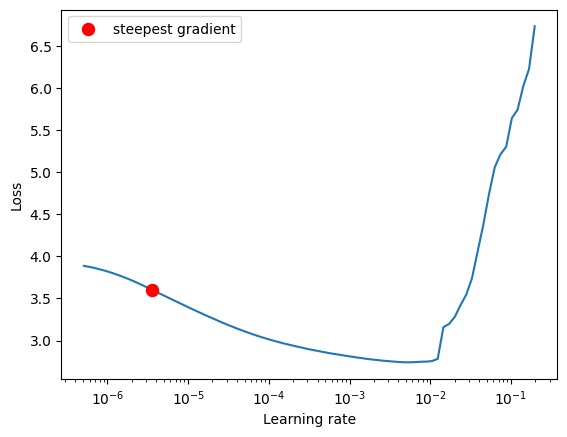

LR Finder plot saved to lr_finder.png

--- LR Finder complete. You can now use the suggested LR for training. ---


In [7]:
from torch_lr_finder import LRFinder, TrainDataLoaderIter
import torch.optim as optim
import torch.nn as nn

class HFTrainLoaderIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data, batch_data["labels"]

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
        return self.model(**inputs)

def hf_criterion(outputs, labels):
    return outputs.loss


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, # Use the same batch size as your main training
    collate_fn=data_collator,
    shuffle=True
)


# --- LR Finder ---
print("\n--- Running Learning Rate Finder ---")

# 1. Wrap the model
wrapped_model = ModelWrapper(model)

# 2. Define optimizer
optimizer = optim.Adam(wrapped_model.parameters(), lr=1e-7, weight_decay=0.01)

# 3. Wrap the DataLoader
hf_train_iter = HFTrainLoaderIter(train_loader)

# 4. Initialize and run the finder
lr_finder = LRFinder(wrapped_model, optimizer, hf_criterion, device=DEVICE)
lr_finder.range_test(hf_train_iter, end_lr=1, num_iter=100)

# 5. Plot and reset
lr_finder.plot() # Saves lr_finder.png
print("LR Finder plot saved to lr_finder.png")
lr_finder.reset()

print("\n--- LR Finder complete. You can now use the suggested LR for training. ---")



In [8]:
tokenizer.decode([3])

'[UNK]'

In [9]:
train_dataset.strings[:5]

['v0 v10 v12 v0 v5 v4 v6 v1 v8 v12 v10 v14 v1 v5 v4 v8 v14 v6',
 'v13 v6 v14 v0 v12 v11 v11 v14 v6 v7 v8 v1 v1 v13 v0 v8 v7 v12',
 'v3 v6 v4 v3 v10 v0 v6 v10 v13 v9 v9 v4 v5 v8 v0 v5 v8 v13',
 'v2 v5 v6 v1 v0 v13 v3 v12 v11 v3 v13 v6 v12 v2 v1 v11 v5 v0',
 'v12 v10 v8 v13 v4 v8 v10 v11 v14 v9 v11 v4 v13 v2 v2 v14 v9 v12']

In [10]:
collate_fn([train_dataset[0], train_dataset[3]], tokenizer=tokenizer)

{'input_ids': tensor([[19, 44, 42, 46, 45, 25,  4, 14, 16,  4,  9,  8, 10,  5, 12, 16, 14, 18,
           5,  9,  8, 12, 18, 10, 20],
         [19, 23, 24, 25, 31, 36,  6,  9, 10,  5,  4, 17,  7, 16, 15,  7, 17, 10,
          16,  6,  5, 15,  9,  4, 20]]),
 'labels': tensor([[-100, -100, -100, -100, -100, -100,    4,   14,   16,    4,    9,    8,
            10,    5,   12,   16,   14,   18,    5,    9,    8,   12,   18,   10,
            20],
         [-100, -100, -100, -100, -100, -100,    6,    9,   10,    5,    4,   17,
             7,   16,   15,    7,   17,   10,   16,    6,    5,   15,    9,    4,
            20]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1]])}

In [11]:
tokenizer.decode([19, 44, 42, 46, 45, 25,  4, 14, 16,  4,  9,  8, 10,  5, 12, 16, 14, 18,
           5,  9,  8, 12, 18, 10, 20])
# tokenizer.decode([662, 1729,    4, 2510])

'<BOS> <H23> <H21> <H25> <H24> <H4> v0 v10 v12 v0 v5 v4 v6 v1 v8 v12 v10 v14 v1 v5 v4 v8 v14 v6 <EOS>'

In [12]:
train_perms_set = set(train_perms)
print(f"Training permutations set size: {len(train_perms_set)}")

def is_coherent_after_walk(seq, N, vocab_ids=VOCAB_IDs) -> bool:
    """
    Given that π exists (walk succeeded), check coherence:
    - correct number of edges
    - correct tokens
    """
    if len(seq) != 2 * N:
        return False

    vocab_set = set(vocab_ids)
    if any(token not in vocab_set for token in seq):
        return False

    return True

def evaluate_model(model, 
                greedy, 
                temperature, 
                label, 
                decode_fn, 
                train_dataset, 
                seed=42, 
                batch_size=eval_batch_size, 
                num_eval_samples=num_eval_samples,
                top_p=top_p):
    set_seed(seed)
    print(f"\nEvaluating {label} for seed {seed}...")

    samples, outputs, input_lengths  = generate_samples(model, 
                                        train_dataset, 
                                        tokenizer,
                                        decode_fn=decode_fn, 
                                        greedy=greedy, 
                                        seed_tokens=SEED_TOKENS, 
                                        seed_len=HL, 
                                        max_length=train_dataset[1]["labels"].shape[0]*2,
                                        temperature=temperature, 
                                        top_p=top_p, 
                                        num_samples=num_eval_samples, 
                                        batch_size=batch_size
                                        )
    tokenized_samples = [EVAL_TOKENIZER.encode(s) for s in samples]

    unique_perms = set()
    unique_coherent_perms = set()
    num_coherent = 0
    incoherent_samples = []
    # Final metrics loop
    for s in tokenized_samples:
        pi = compute_canonical_permutation(s, N=N)
        if pi is not None:
            unique_perms.add(pi)
            if is_coherent_after_walk(s, N=N, vocab_ids=VOCAB_IDs):
                num_coherent += 1
                unique_coherent_perms.add(pi)
            else:
                incoherent_samples.append(s)
        else:
            incoherent_samples.append(s)

    num_memorized = len([s for s in unique_coherent_perms if s in train_perms_set])
    num_creative = len([s for s in unique_coherent_perms if s not in train_perms_set])
    num_unique = len(unique_perms)

    representation_power = (num_memorized / len(samples))
    creativity = (num_creative / len(samples)) 
    uniqueness = (num_unique / len(samples)) 
    coherence = (num_coherent / len(samples)) 
    # perplexity = compute_perplexity(model, test_dataset, batch_size=batch_size)

    # print(f"Perplexity: {perplexity:.4f}")
    print(f"Coherence: {coherence:.4f} ({num_coherent}/{len(samples)})")
    print(f"Representation power: {representation_power:.4f} ({num_memorized}/{len(samples)})")
    print(f"Creativity: {creativity:.4f} ({num_creative}/{len(samples)})")
    print(f"Uniqueness: {uniqueness:.4f} ({num_unique}/{len(samples)})")

    print("Generated samples:", samples[:5])
    return np.array([
        representation_power,
        creativity,
        uniqueness,
        coherence,
    ])

Training permutations set size: 8870


In [13]:
train_main(
    model=model,
    dataset_name=dataset_name,
    save_name=save_name,
    batch_size=batch_size,
    num_epochs=epochs,
    temperatures=[0.3, 0.5, 0.7, 1.0, 2.0],
    num_eval_runs=eval_runs,
    train_dataset=train_dataset,
    data_collator=data_collator,
    device=DEVICE,
    decode_fn=None,
    eval_fn=None,
    num_checkpoints=num_ckpts,
    log_to_wandb=False,
    save_results=False, 
    lr=5e-5
)

{'loss': 2.8501, 'grad_norm': 2.1948249340057373, 'learning_rate': 4.996974522292994e-05, 'epoch': 0.12738853503184713}
{'loss': 2.595, 'grad_norm': 1.4879429340362549, 'learning_rate': 4.993789808917197e-05, 'epoch': 0.25477707006369427}
{'loss': 2.5819, 'grad_norm': 1.2038607597351074, 'learning_rate': 4.9906050955414014e-05, 'epoch': 0.3821656050955414}
{'loss': 2.5787, 'grad_norm': 1.5140697956085205, 'learning_rate': 4.987420382165605e-05, 'epoch': 0.5095541401273885}
{'loss': 2.5711, 'grad_norm': 1.456027865409851, 'learning_rate': 4.984235668789809e-05, 'epoch': 0.6369426751592356}
{'loss': 2.5404, 'grad_norm': 1.996604323387146, 'learning_rate': 4.9810509554140126e-05, 'epoch': 0.7643312101910829}
{'loss': 2.437, 'grad_norm': 2.852355718612671, 'learning_rate': 4.977866242038217e-05, 'epoch': 0.89171974522293}


KeyboardInterrupt: 

In [18]:
evaluate_model(model, greedy=False, temperature=0.5, label="something", decode_fn=decode_batch, train_dataset=train_dataset)


Evaluating something for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2370 (237/1000)
Representation power: 0.0560 (56/1000)
Creativity: 0.1740 (174/1000)
Uniqueness: 0.2300 (230/1000)
Generated samples: ['v7 v14 v5 v13 v8 v6 v1 v7 v14 v8 v6 v1 v13 v12 v12 v10 v10 v5', 'v1 v14 v9 v8 v5 v1 v8 v10 v14 v11 v13 v6 v10 v13 v6 v5 v11 v9', 'v3 v2 v11 v12 v2 v11 v12 v8 v13 v4 v8 v13 v10 v6 v4 v10 v6 v3', 'v2 v0 v1 v9 v9 v12 v6 v2 v0 v8 v12 v6 v8 v5 v5 v4 v4 v1', 'v13 v12 v9 v13 v8 v6 v4 v2 v2 v0 v12 v8 v0 v9 v6 v10 v10 v4']


array([0.056, 0.174, 0.23 , 0.237])

In [11]:
EVAL_TOKENIZER.encode("v10 v11 v11 v14 v12 v13 v14 v1 v1 v12 v10 v11 v2 v2 v15 v7 v16 v15 v7 v16 v13 v1 v14 v13 v11 v4")

[14,
 15,
 15,
 18,
 16,
 17,
 18,
 5,
 5,
 16,
 14,
 15,
 6,
 6,
 3,
 11,
 3,
 3,
 11,
 3,
 17,
 5,
 18,
 17,
 15,
 8]

In [12]:
compute_canonical_permutation([14,
 15,
 15,
 18,
 16,
 17,
 18,
 5,
 5,
 16,
 14,
 15,
 6,
 6,
 3,
 11,
 3,
 3,
 11,
 3,
 17,
 5,
 18,
 17,
 15,
 8], N=9)

In [15]:
generate_samples(model, train_dataset, tokenizer, max_length=100, num_samples=5, top_p=1.0, temperature=1.0, decode_fn=
                 decode_batch, greedy=False, batch_size=256, seed_tokens=SEED_TOKENS, seed_len=HL)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Generating 5 unconditional samples.


(['2 v5',
  '5 v4 v9',
  '0 v2reale Schnee bibliote2',
  ' v14 v2 v13 v0 v2 v14 v1 v4 v0 v12 v4 v12 v3 v3 v12 v13 v11 v9 v9 v3 v11 v2 v7 v7 v3',
  ' v12 v12 v7 v14 v6 v6 v8 v2 v4 v8 v2 v4 v14 v3 v3 v13 v13 v11 v14 v13 v3 v2 v8 v12 v12 v9 v9 v3 v4 v6 v0 v0 v3'],
 {'input_ids': tensor([[     2, 256000, 235284,    593, 235308, 256001, 256001, 256001, 256001,
           256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001,
           256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001,
           256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001,
           256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001,
           256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001,
           256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001,
           256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001, 256001,
           256001, 256001, 256001, 256001, 256001, 256001, 25

samples, s

In [16]:
visualize_attention_weights(model, tokenizer, train_dataset, temperature=1.0, step=100, save_path="None", num_samples=100, max_length=100)


--- Generating 100 samples for attention analysis at step 100 ---
Processing 16 samples (Batch 1)

Generating 16 unconditional samples.
Processing 16 samples (Batch 2)

Generating 16 unconditional samples.
Processing 16 samples (Batch 3)

Generating 16 unconditional samples.
Processing 16 samples (Batch 4)

Generating 16 unconditional samples.
Processing 16 samples (Batch 5)

Generating 16 unconditional samples.
Processing 16 samples (Batch 6)

Generating 16 unconditional samples.
Processing 4 samples (Batch 7)

Generating 4 unconditional samples.

Saving plots to directory: None/step_100

--- Processing Attention for Layer 0 ---
Averaging attention maps for 13 samples of length 9.
--- Example Samples Being Averaged ---
[1] '3 tuned v1 v1'
[2] '1 v4 v11'
[3] '1 v6 v11'
[4] ' v5 v0 seriousness geben'
[5] ' ctl2 v4 v7'
------------------------------------
Using tick step 1 and font size 13 for sequence length 9.

Saved grid of attention heatmaps to None/step_100/layer0_attentions.png

-